- Plot time-series images for each landfill and check if emissions depend on wind speed
- Pick cases to compare emission rates with Sentinel-2 RGB image

In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
from itertools import chain
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from pystac_client import Client
import cartopy.crs as ccrs
import string
import rioxarray
import xarray as xr
from odc.stac import load
from matplotlib.ticker import FormatStrFormatter, AutoMinorLocator

In [2]:
from matplotlib import rcParams
font_size = 17
rcParams['axes.titlesize'] = font_size
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelsize'] = font_size - 2
rcParams['xtick.labelsize'] = font_size - 2
rcParams['ytick.labelsize'] = font_size - 2
rcParams['legend.fontsize'] = font_size
rcParams['figure.titlesize'] = font_size
rcParams['figure.titleweight'] = 'bold'

## Read data

In [3]:
data_dir = '../data/Hyper_TROPOMI_landfill/'

filelist = list(chain(*[glob(os.path.join(data_dir, '**', '*csv'), recursive=True)]))
df = pd.concat((pd.read_csv(f) for f in filelist), ignore_index=True)

# add shape error
df['emission_uncertainty'] = np.sqrt(df['emission_uncertainty']**2+(df['emission']*0.05)**2)

# add percentage error
df['emission_uncertainty_percentage'] = df['emission_uncertainty']/df['emission']*100

# convert units from kg/h to t/h
df['emission'] /= 1e3
df['emission_uncertainty'] /= 1e3

df_emiss = df.groupby(['country', 'name'], as_index=False).agg({'emission':'mean', 'emission_uncertainty_percentage': 'mean', 'plume_id': 'count'}).rename(columns={'plume_id': 'count'})
# df_emiss = df.groupby(['country', 'name'], as_index=False).agg({'emission':'mean'})#, 'emission_uncertainty_percentage': 'mean', 'plume_id': 'count'}).rename(columns={'plume_id': 'count'})

In [4]:
df_emiss

,country,name,emission,emission_uncertainty_percentage,count
0,Argentina,González Catán,3.071510,34.441535,5
1,Argentina,Norte III,19.757041,31.091429,8
2,Argentina,Piedra Blanca,2.709553,40.599091,2
3,Bangladesh,Aminbazar,6.878776,36.755979,1
4,Brazil,Caieiras,14.248087,36.316468,1
5,Brazil,Pedreira,10.991205,38.411063,1
6,China,Ürümqi,8.210699,42.648459,5
7,India,Bandhwari,3.035828,35.265715,4
8,India,Bhalswa,2.017209,37.640534,6
9,India,Deonar,2.677521,46.203740,2


## Landfills with multiple plume OBS

In [5]:
# get landfills have multiple OBS
landfill_name_all = df_emiss[df_emiss['count']>1].sort_values(by=['count'], ascending=False)['name']

# get top 5 landfill which has multiple valid emission rates
landfill_name_tseries = df_emiss.sort_values(by=['count'], ascending=False).iloc[:5]['name']

df_tseries_all = df[df['name'].isin(landfill_name_all)]
df_tseries_all['datetime'] = pd.to_datetime(df_tseries_all['datetime'])

df_tseries = df[df['name'].isin(landfill_name_tseries)]
df_tseries['datetime'] = pd.to_datetime(df_tseries['datetime'])

/var/folders/n2/jdncdjcx465bv0ls_nyvsqx40000gn/T/ipykernel_92480/1199488639.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tseries_all['datetime'] = pd.to_datetime(df_tseries_all['datetime'])
/var/folders/n2/jdncdjcx465bv0ls_nyvsqx40000gn/T/ipykernel_92480/1199488639.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tseries['datetime'] = pd.to_datetime(df_tseries['datetime'])


In [6]:
print(len(landfill_name_all), 'landfills are observed at least twice.')

28 landfills are observed at least twice.


In [7]:
len(df_emiss[df_emiss['count']>=8])

10

In [8]:
# TOP 5 landfills
df_tseries['name'].drop_duplicates()

8         Kabd
108     Riyadh
137     Dudaim
146      Tamar
159    Ghabawi
Name: name, dtype: object

### Plotting function

In [9]:
def plot_errorbar_stats(ax, df, title, color='royalblue', xaxis='datetime'):
    import matplotlib.dates as mdates

    platform_marker_dict = {'EMIT': 'royalblue', 'EnMAP': 'orange', 'PRISMA': 'gray'}
    platform_list = df['platform'].drop_duplicates().to_list()

    for platform in platform_list:
        df_platform = df[df['platform']==platform].sort_values(by=[xaxis])

        ax.errorbar(df_platform[xaxis],
                    df_platform['emission'],
                    yerr=df_platform['emission_uncertainty'],
                    marker='o', linestyle="none",
                    # c=color,
                    c=platform_marker_dict[platform],
                    # mfc=platform_marker_dict[platform],
                    capsize=3, capthick=1, label=platform)
        # plt.legend(numpoints=1)

        if xaxis == 'datetime':
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
            ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y-%m"))
            # plt.xticks(rotation=45, ha='center')

        for label in ax.get_xticklabels():
            label.set_ha("center")
            label.set_rotation(45)
    
    ax.set_ylim(ymin=0)

    # ax.errorbar(df.sort_values(by=['datetime'])['datetime'],
    #             df.sort_values(by=['datetime'])['emission'],
    #             yerr=0,
    #             marker='o', c=color, markerfacecolor='none',
    #             capsize=3, capthick=1)
    ax.set_title(title)

## Landfill emission time-series

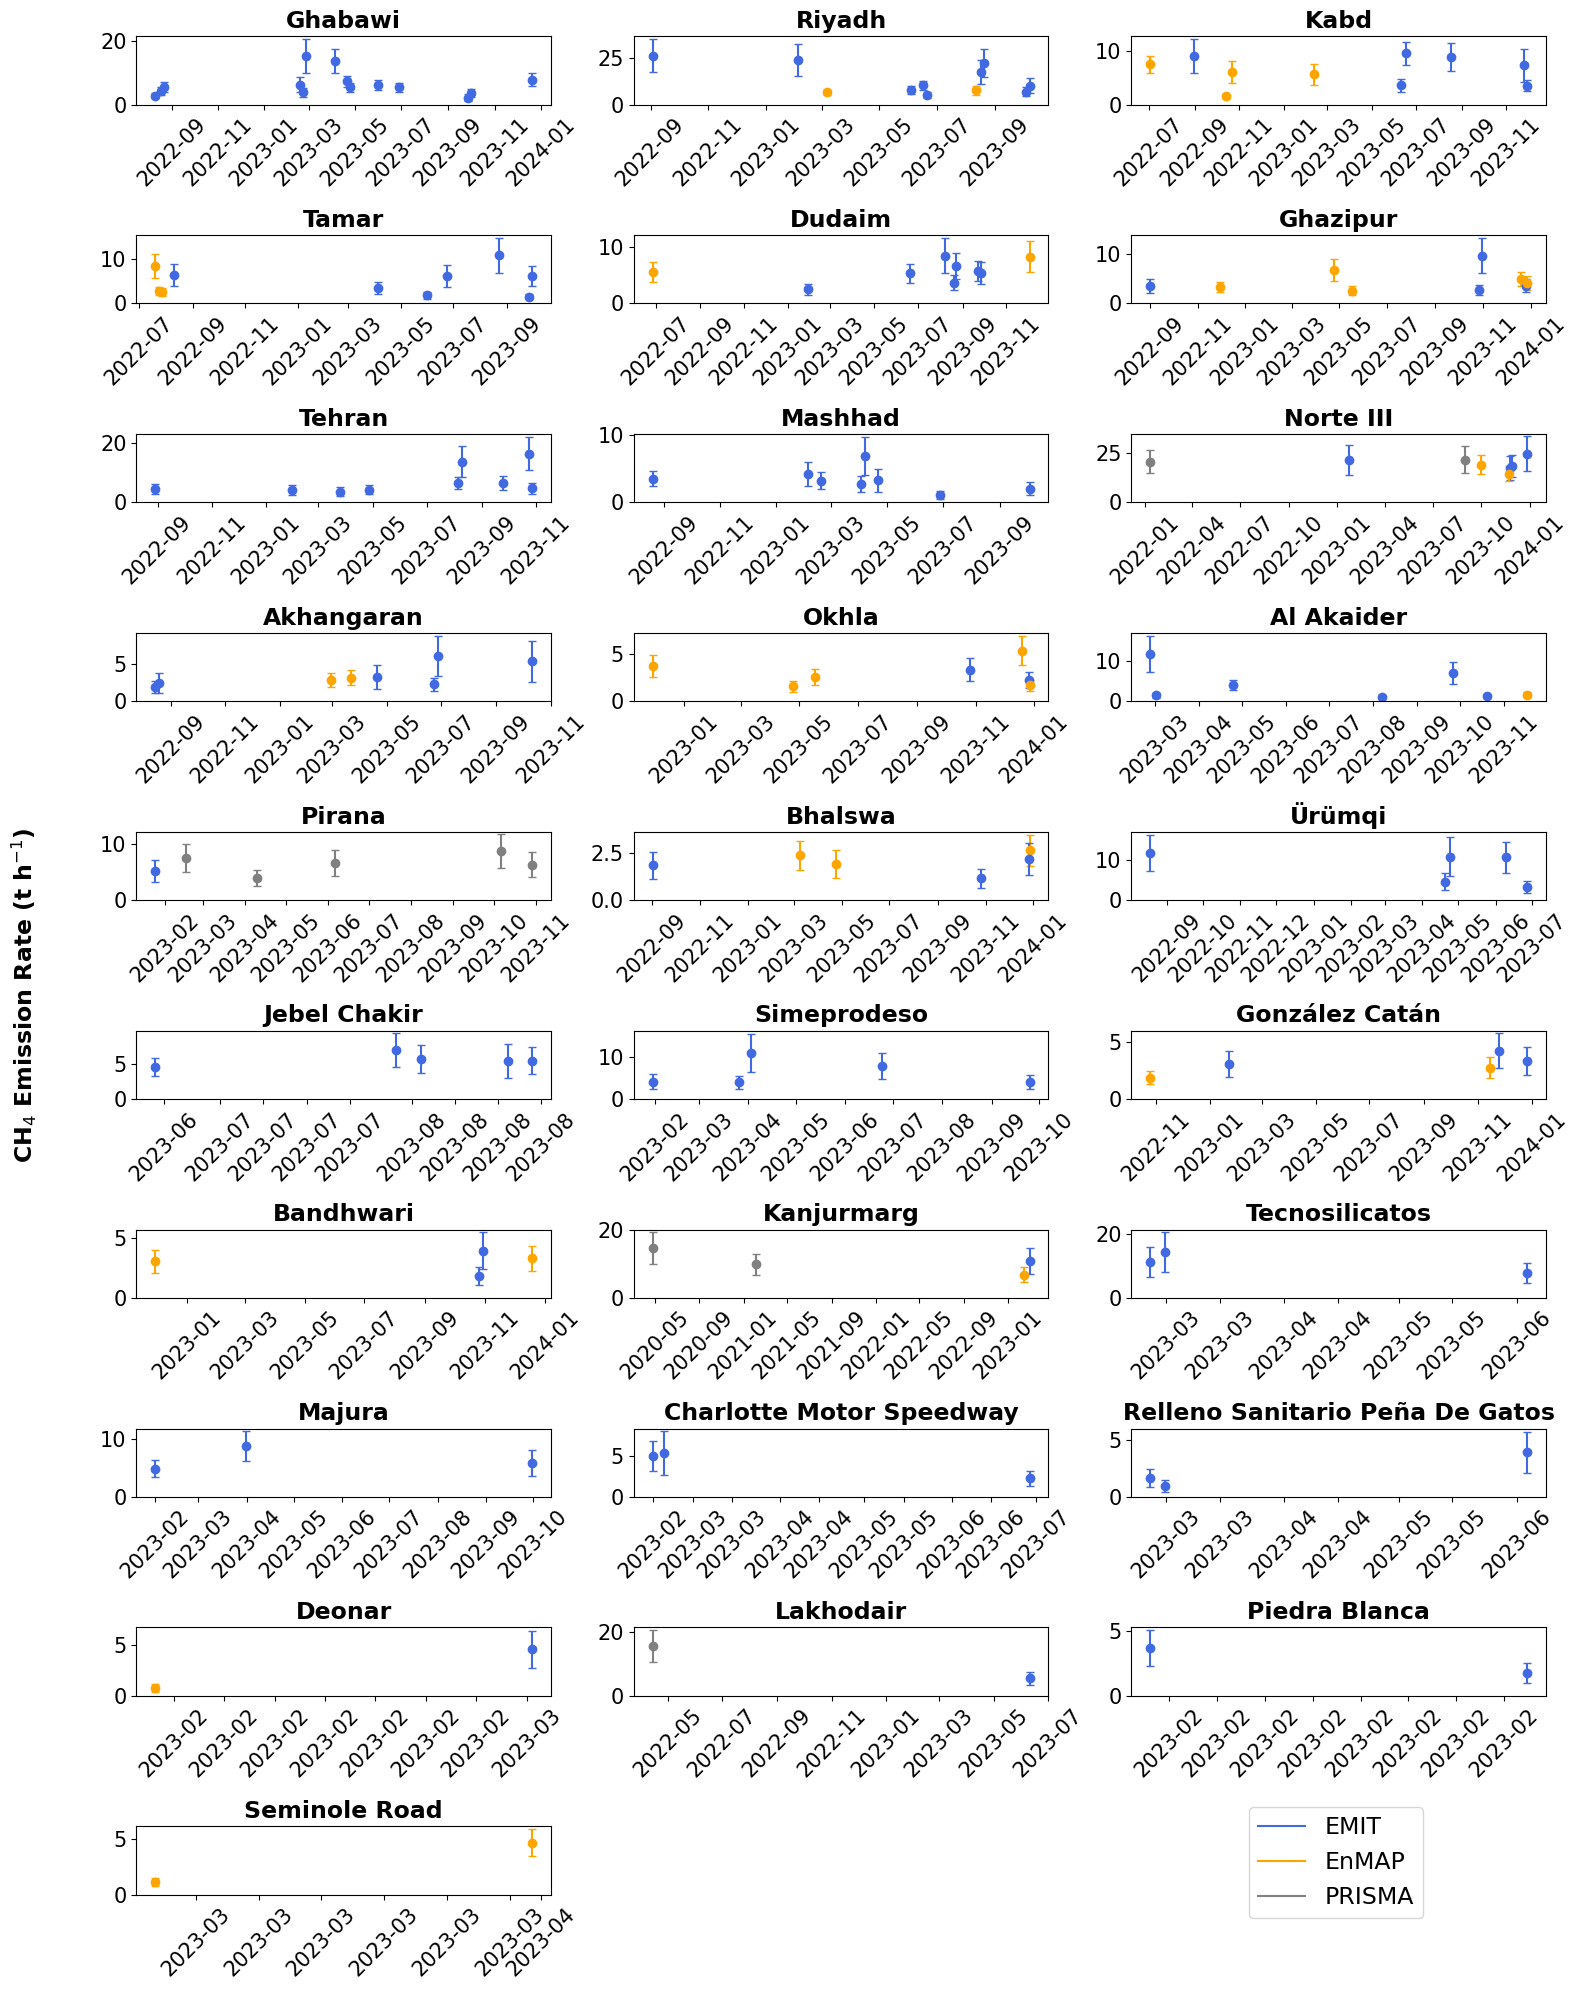

In [10]:
ncols = 3
nrows = int(np.ceil(len(landfill_name_all)/ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 20))#, sharex=True)
axs = axs.flatten()

for index,name in enumerate(landfill_name_all):
    plot_errorbar_stats(axs[index], df_tseries_all[df_tseries_all['name']==name], title=name)

fig.tight_layout()

empty_fig_num = nrows*ncols - len(landfill_name_all)
if empty_fig_num > 0:
    for i in range(empty_fig_num):
        axs[-i-1].axis('off')

fig.legend(
    loc='upper right',
    bbox_to_anchor=(0.9, 0.1),
    handles=[
        Line2D([], [], c='royalblue', label="EMIT"),
        Line2D([], [], c='orange', label="EnMAP"),
        Line2D([], [], c='gray', label="PRISMA"),
    ]
)

for ax in axs:
    ax.set_ylim(ymin=0)

# fig.text(0.5, -0.02, 'Date', ha='center', size=font_size, fontweight='bold')
fig.text(-0.05, 0.5, 'CH$_4$ Emission Rate (t h$^{-1}$)', va='center', rotation='vertical', size=font_size, fontweight='bold')

fig.tight_layout()
fig.savefig('../figures/emission_tseries_all.pdf', bbox_inches='tight')

## Relationship between emissions and wind speed

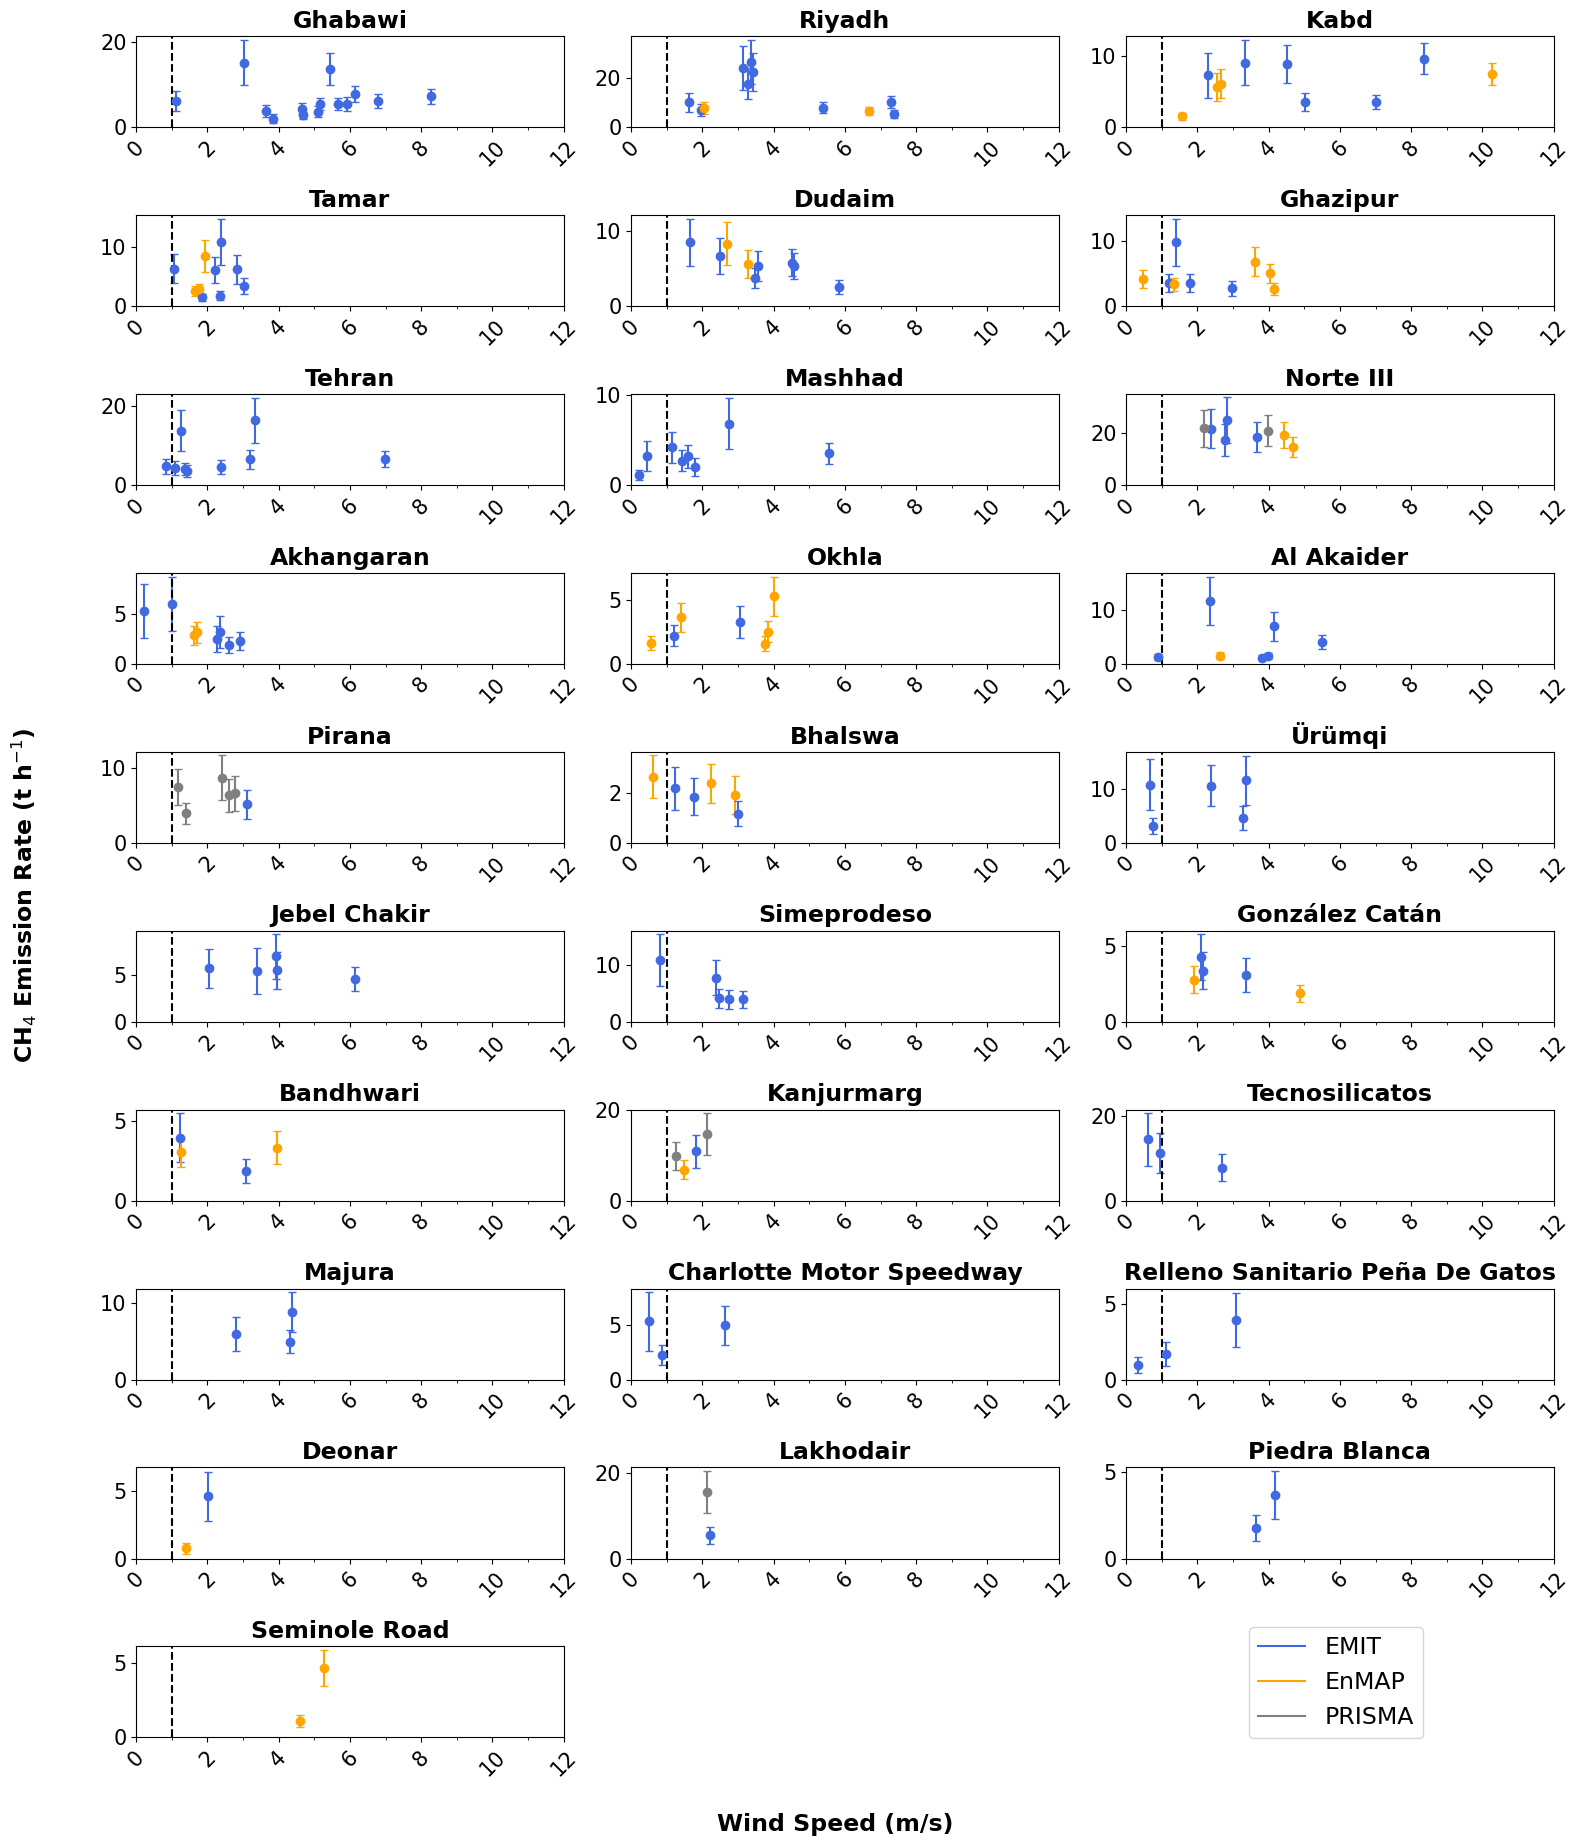

In [11]:
ncols = 3
nrows = int(np.ceil(len(landfill_name_all)/ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 18))
axs = axs.flatten()

for index,name in enumerate(landfill_name_all):
    plot_errorbar_stats(axs[index], df_tseries_all[df_tseries_all['name']==name], title=name, xaxis='wind_speed')
fig.tight_layout()

empty_fig_num = nrows*ncols - len(landfill_name_all)
if empty_fig_num > 0:
    for i in range(empty_fig_num):
        axs[-i-1].axis('off')

fig.legend(
    loc='upper right',
    bbox_to_anchor=(0.9, 0.1),
    handles=[
        Line2D([], [], c='royalblue', label="EMIT"),
        Line2D([], [], c='orange', label="EnMAP"),
        Line2D([], [], c='gray', label="PRISMA"),
    ]
)

for ax in axs[:-empty_fig_num]:
    ax.axvline(x=1, c='k', linestyle='--')
    ax.set_xlim(0, 12)
    ax.set_ylim(ymin=0)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))

fig.text(0.5, -0.02, 'Wind Speed (m/s)', ha='center', size=font_size, fontweight='bold')
fig.text(-0.05, 0.5, 'CH$_4$ Emission Rate (t h$^{-1}$)', va='center', rotation='vertical', size=font_size, fontweight='bold')

fig.tight_layout()
fig.savefig('../figures/emission_wspd_all.pdf', bbox_inches='tight')

## Landfill cases

### Norte III

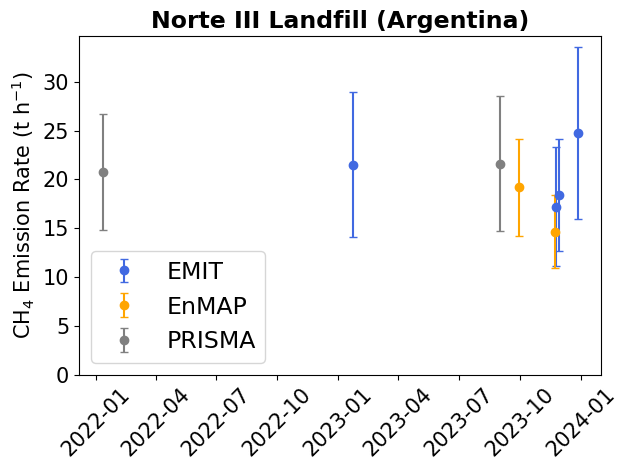

In [12]:
fig, ax = plt.subplots()

plot_errorbar_stats(ax, df_tseries_all[df_tseries_all['name']=='Norte III'], title='Norte III Landfill (Argentina)')
ax.set_ylabel('CH$_4$ Emission Rate (t h$^{-1}$)')
ax.set_xlabel('')
plt.legend(numpoints=1)

fig.tight_layout()

### Ghabawi

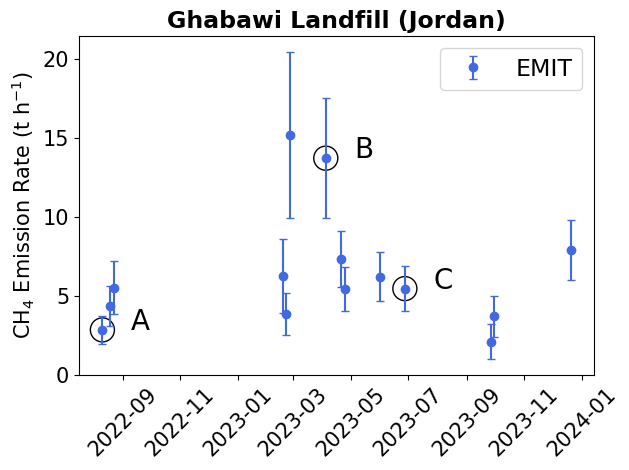

In [13]:
fig, ax = plt.subplots()

df_subset_Ghabawi = df_tseries[df_tseries['name']=='Ghabawi'].sort_values('datetime')
plot_errorbar_stats(ax, df_subset_Ghabawi, title='Ghabawi Landfill (Jordan)')
ax.set_ylabel('CH$_4$ Emission Rate (t h$^{-1}$)')
ax.set_xlabel('')
plt.legend(numpoints=1)

# first case
ax.scatter(df_subset_Ghabawi.iloc[0]['datetime'], df_subset_Ghabawi.iloc[0]['emission'], facecolors='none', edgecolors='k', s=300)
ax.text(df_subset_Ghabawi.iloc[0]['datetime']+pd.Timedelta(days=30), df_subset_Ghabawi.iloc[0]['emission'], 'A', fontsize=20)

# second case
ax.scatter(df_subset_Ghabawi.iloc[6]['datetime'], df_subset_Ghabawi.iloc[6]['emission'], facecolors='none', edgecolors='k', s=300)
ax.text(df_subset_Ghabawi.iloc[6]['datetime']+pd.Timedelta(days=30), df_subset_Ghabawi.iloc[6]['emission'], 'B', fontsize=20)

# third case
ax.scatter(df_subset_Ghabawi.iloc[-4]['datetime'], df_subset_Ghabawi.iloc[-4]['emission'], facecolors='none', edgecolors='k', s=300)
ax.text(df_subset_Ghabawi.iloc[-4]['datetime']+pd.Timedelta(days=30), df_subset_Ghabawi.iloc[-4]['emission'], 'C', fontsize=20)


fig.tight_layout()

In [14]:
df_subset_Ghabawi[['datetime', 'emission', 'emission_uncertainty']]

,datetime,emission,emission_uncertainty
164,2022-08-10 06:50:21,2.834856,0.866083
166,2022-08-18 11:44:40,4.341906,1.286142
168,2022-08-22 10:06:53,5.508502,1.697793
160,2023-02-17 11:16:03,6.244133,2.369030
172,2023-02-21 09:39:54,3.862508,1.335151
165,2023-02-25 08:05:43,15.205535,5.255470
170,2023-04-04 08:59:08,13.713881,3.806255
162,2023-04-20 10:45:34,7.346157,1.767722
167,2023-04-24 09:08:18,5.424613,1.416363
171,2023-05-31 10:23:16,6.206116,1.559574


### Ghazipur

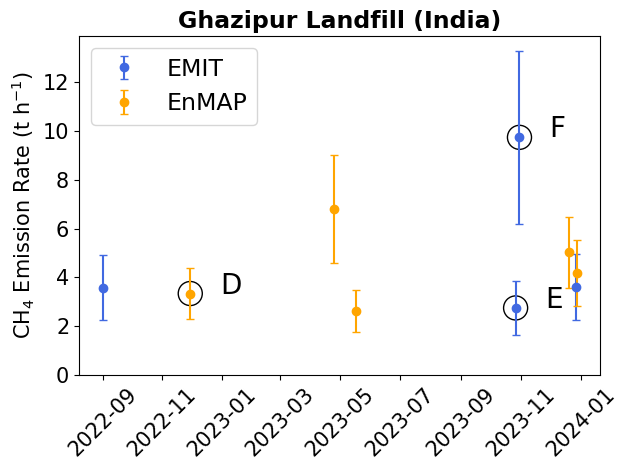

In [15]:
fig, ax = plt.subplots()

df_subset_Ghazipur = df_tseries_all[df_tseries_all['name']=='Ghazipur'].sort_values('datetime')
plot_errorbar_stats(ax, df_subset_Ghazipur, title='Ghazipur Landfill (India)')
ax.set_ylabel('CH$_4$ Emission Rate (t h$^{-1}$)')
ax.set_xlabel('')
plt.legend(numpoints=1)

# first case
ax.scatter(df_subset_Ghazipur.iloc[1]['datetime'], df_subset_Ghazipur.iloc[1]['emission'], facecolors='none', edgecolors='k', s=300)
ax.text(df_subset_Ghazipur.iloc[1]['datetime']+pd.Timedelta(days=30), df_subset_Ghazipur.iloc[1]['emission'], 'D', fontsize=20)

# second case
ax.scatter(df_subset_Ghazipur.iloc[4]['datetime'], df_subset_Ghazipur.iloc[4]['emission'], facecolors='none', edgecolors='k', s=300)
ax.text(df_subset_Ghazipur.iloc[4]['datetime']+pd.Timedelta(days=30), df_subset_Ghazipur.iloc[4]['emission'], 'E', fontsize=20)

# third case
ax.scatter(df_subset_Ghazipur.iloc[5]['datetime'], df_subset_Ghazipur.iloc[5]['emission'], facecolors='none', edgecolors='k', s=300)
ax.text(df_subset_Ghazipur.iloc[5]['datetime']+pd.Timedelta(days=30), df_subset_Ghazipur.iloc[5]['emission'], 'F', fontsize=20)


fig.tight_layout()


In [16]:
df_subset_Ghazipur[['datetime', 'emission', 'emission_uncertainty']]

,datetime,emission,emission_uncertainty
81,2022-09-01 03:46:52,3.571954,1.336591
98,2022-11-29 06:17:07,3.330772,1.043541
91,2023-04-24 06:02:59,6.802909,2.231924
95,2023-05-17 05:58:24,2.620923,0.871629
84,2023-10-26 05:31:30,2.738617,1.108005
83,2023-10-30 03:55:45,9.745077,3.564744
97,2023-12-19 05:59:07,5.018671,1.456648
78,2023-12-26 05:22:36,3.602432,1.354657
88,2023-12-27 06:06:36,4.181127,1.359312


## Sentinel-2 images

### Plotting functions

In [17]:
client = Client.open("https://earth-search.aws.element84.com/v1")
collection = "sentinel-2-l2a"

def gammacorr(band):
    gamma=2
    return np.power(band, 1/gamma)

def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))

def corr_rgb(data):
    rgb_gamma = gammacorr(data)
    rgb_corr = normalize(rgb_gamma)
    return rgb_corr

def get_img(row, bbox, buffer=0.01):
    # search 5 days
    st = (row['datetime'] - pd.Timedelta(days=2)).strftime('%Y-%m-%d')
    et = (row['datetime'] + pd.Timedelta(days=2)).strftime('%Y-%m-%d')

    # point = Point(row['plume_longitude'], row['plume_latitude'])
    # # add the required distance/buffer around the lat lon
    # bbox = point.buffer(buffer).bounds

    # get one clear image in 2023
    search = client.search(collections = [collection],
                            bbox = bbox,
                            datetime = f'{st}/{et}',
                            # query = {"eo:cloud_cover":{"lt":0.8}},
                            # max_items=1,
                            )
    data = load(search.items(), bbox=bbox, groupby="solar_day", chunks={})
    img = data[["red", "green", "blue"]].to_array().rename('rgb')

    img = img.sel(time=row['datetime'], method='nearest').load()

    img = xr.apply_ufunc(corr_rgb,
                         img,
                         input_core_dims=[['y', 'x', 'variable']],
                         output_core_dims=[['y', 'x', 'variable']],
                         vectorize=True,
                         )

    return img.transpose('variable', 'y', 'x')

def plot_s2(ax, img):
    img = img.rio.reproject('EPSG:4326')
    img = img.where(img!=img.rio.nodata)
    img.plot.imshow(ax=ax, robust=True, rasterized=True)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_title('')
    # ax.set_title(img.time.dt.strftime('%Y-%m-%d').item())

In [18]:
def plot_case(axs, row, num, data_dir, pad=0.012, extent=None):
    '''
    row: Series
    num: A,B, C index
    data_dir: where plume NC files are saved
    extent: overwrite the calculated extent
    '''
    if extent is None:
        # set extent
        lon_min = row['plume_longitude'] - pad
        lon_max = row['plume_longitude'] + pad
        lat_min = row['plume_latitude'] - pad
        lat_max = row['plume_latitude'] + pad
        extent = (lon_min, lon_max, lat_min, lat_max)

    ax = axs[0]
    ax.set_extent(extent)

    img = get_img(row, bbox=(extent[0], extent[2], extent[1], extent[3]))
    plot_s2(ax, img)

    ax = axs[1]
    l3_filename = glob(f'{data_dir}/*'+row['plume_id'].upper().split('-')[1]+'*.nc')[0]

    print(l3_filename)
    ds = xr.open_dataset(l3_filename)
    ch4_plume = ds['ch4'].dropna(dim='x', how='all').dropna(dim='y', how='all')

    plot_s2(ax, img)

    m = ch4_plume.plot(ax=ax, x='longitude', y='latitude', vmin=0, vmax=300, cmap='plasma', add_colorbar=False, rasterized=True)

    # ax.set_title(ch4_plume.attrs['start_time'][:10])
    ax.set_title('')
    ax.set_extent(extent)

    for ax in axs:
        ax.text(0.02, 0.86, string.ascii_uppercase[num],
                transform=ax.transAxes, 
                size=20, weight='bold', c='w')

    return m, extent

In [19]:
def plot_case_plume(ax, row, num, data_dir, pad=0.012, extent=None):
    '''
    row: Series
    num: A,B, C index
    data_dir: where plume NC files are saved
    extent: overwrite the calculated extent
    '''
    if extent is None:
        # set extent
        lon_min = row['plume_longitude'] - pad
        lon_max = row['plume_longitude'] + pad
        lat_min = row['plume_latitude'] - pad
        lat_max = row['plume_latitude'] + pad
        extent = (lon_min, lon_max, lat_min, lat_max)

    ax.set_extent(extent)
    img = get_img(row, bbox=(extent[0], extent[2], extent[1], extent[3]))

    l3_filename = glob(f'{data_dir}/*'+row['plume_id'].upper().split('-')[1]+'*.nc')[0]
    print(l3_filename)
    ds = xr.open_dataset(l3_filename)
    ch4_plume = ds['ch4'].dropna(dim='x', how='all').dropna(dim='y', how='all')

    plot_s2(ax, img)
    m = ch4_plume.plot(ax=ax, x='longitude', y='latitude', vmin=0, vmax=300, alpha=0.5,
                       cmap='plasma', add_colorbar=False, rasterized=True)

    # ax.set_title(ch4_plume.attrs['start_time'][:10])
    ax.set_title('')
    ax.set_extent(extent)
    
    ax.text(0.02, 0.86, string.ascii_uppercase[num],
            transform=ax.transAxes, 
            size=20, weight='bold', c='w')

    return m, extent

In [20]:
# a = list(map(str, range(18)))
# axis_proj = tuple(filter(lambda v: v not in ['0', '8', '9'], a))

# fig, axs = plt.subplot_mosaic([['1', '2', '3', '4', '5', '6'],
#                                ['7', '8', '8', '9', '9', '10'],
#                                ['11', '8', '8', '9', '9', '12'],
#                                ['13', '14', '15', '16', '17', '18']
#                                ],
#                                per_subplot_kw={axis_proj: {"projection": ccrs.PlateCarree()}},
#                                figsize=(15, 10),
#                                constrained_layout=True,
#                                )


# # --- time series ---
# ax = axs['8']
# df_subset_Ghabawi = df_tseries[df_tseries['name']=='Ghabawi'].sort_values('datetime')
# plot_errorbar_stats(ax, df_subset_Ghabawi, title='Ghabawi Landfill (Jordan)')
# ax.set_ylabel('CH$_4$ Emission Rate (t h$^{-1}$)')

# # first case
# ax.scatter(df_subset_Ghabawi.iloc[4]['datetime'], df_subset_Ghabawi.iloc[4]['emission'], facecolors='none', edgecolors='k', s=300)
# ax.text(df_subset_Ghabawi.iloc[4]['datetime']+pd.Timedelta(days=30), df_subset_Ghabawi.iloc[4]['emission'], 'A', fontsize=20)

# # second case
# ax.scatter(df_subset_Ghabawi.iloc[6]['datetime'], df_subset_Ghabawi.iloc[6]['emission'], facecolors='none', edgecolors='k', s=300)
# ax.text(df_subset_Ghabawi.iloc[6]['datetime']+pd.Timedelta(days=30), df_subset_Ghabawi.iloc[6]['emission'], 'B', fontsize=20)

# # third case
# ax.scatter(df_subset_Ghabawi.iloc[-3]['datetime'], df_subset_Ghabawi.iloc[-3]['emission'], facecolors='none', edgecolors='k', s=300)
# ax.text(df_subset_Ghabawi.iloc[-3]['datetime']+pd.Timedelta(days=30), df_subset_Ghabawi.iloc[-3]['emission'], 'C', fontsize=20)

# # ax.text(0.9, 0.92, string.ascii_uppercase[0],
# #         transform=ax.transAxes, 
# #         size=20, weight='bold')

# # --- time series ---

# ax = axs['9']
# df_subset_Ghazipur = df_tseries_all[df_tseries_all['name']=='Ghazipur'].sort_values('datetime')
# plot_errorbar_stats(ax, df_subset_Ghazipur, title='Ghazipur Landfill (India)')

# # first case
# ax.scatter(df_subset_Ghazipur.iloc[1]['datetime'], df_subset_Ghazipur.iloc[1]['emission'], facecolors='none', edgecolors='k', s=300)
# ax.text(df_subset_Ghazipur.iloc[1]['datetime']+pd.Timedelta(days=30), df_subset_Ghazipur.iloc[1]['emission'], 'D', fontsize=20)

# # second case
# ax.scatter(df_subset_Ghazipur.iloc[3]['datetime'], df_subset_Ghazipur.iloc[3]['emission'], facecolors='none', edgecolors='k', s=300)
# ax.text(df_subset_Ghazipur.iloc[3]['datetime']-pd.Timedelta(days=50), df_subset_Ghazipur.iloc[3]['emission'], 'E', fontsize=20)

# # third case
# ax.scatter(df_subset_Ghazipur.iloc[-4]['datetime'], df_subset_Ghazipur.iloc[-4]['emission'], facecolors='none', edgecolors='k', s=300)
# ax.text(df_subset_Ghazipur.iloc[-4]['datetime']-pd.Timedelta(days=50), df_subset_Ghazipur.iloc[-4]['emission'], 'F', fontsize=20)

# # ax.text(0.9, 0.92, string.ascii_uppercase[1],
# #         transform=ax.transAxes, 
# #         size=20, weight='bold')


# # -- Ghabawi cases --
# _, extent = plot_case([axs['2'], axs['3']], df_subset_Ghabawi.iloc[4], num=0, data_dir='../data/tseries/Ghabawi')
# plot_case([axs['7'], axs['11']], df_subset_Ghabawi.iloc[6], num=1, data_dir='../data/tseries/Ghabawi', extent=extent)
# plot_case([axs['14'], axs['15']], df_subset_Ghabawi.iloc[-3], num=2, data_dir='../data/tseries/Ghabawi', extent=extent)

# # add cell annotations
# for ax in [axs['2'], axs['7'], axs['14']]:
#     ax.vlines(x=[36.188, 36.1934], ymin=31.9250, ymax=31.9290, colors='w', zorder=10)
#     ax.hlines(y=[31.9250, 31.9270, 31.9290], xmin=36.188, xmax=36.1934, colors='w', zorder=10)
#     ax.text(36.177, 31.9275, 'Cell #1', c='w', fontweight='bold', fontsize=15)
#     ax.text(36.177, 31.9245, 'Cell #2', c='w', fontweight='bold', fontsize=15)

# # -- Ghazipur cases --
# _, extent = plot_case([axs['4'], axs['5']], df_subset_Ghazipur.iloc[1], num=3, data_dir='../data/tseries/Ghazipur', pad=0.007)
# plot_case([axs['10'], axs['12']], df_subset_Ghazipur.iloc[3], num=4, data_dir='../data/tseries/Ghazipur', pad=0.007, extent=extent)
# m, extent  = plot_case([axs['16'], axs['17']], df_subset_Ghazipur.iloc[-4], num=5, data_dir='../data/tseries/Ghazipur', pad=0.007, extent=extent)

# for ax in [axs['1'], axs['6'], axs['13'], axs['18']]:
#     ax.axes.get_xaxis().set_visible(False)
#     ax.axes.get_yaxis().set_visible(False)
#     ax.set_axis_off()


# axs['8'].legend(
#     loc='upper left',
#     handles=[
#         Line2D([], [], c='royalblue', label="EMIT"),
#     ]
# )

# axs['9'].legend(
#     loc='upper left',
#     # bbox_to_anchor=(0.95, 0.1),
#     handles=[
#         Line2D([], [], c='royalblue', label="EMIT"),
#         Line2D([], [], c='orange', label="EnMAP"),
#     ]
# )

# for ax in [axs['8'], axs['9']]:
#     ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#     ax.set_ylim(0, 20)
# axs['9'].set_yticklabels([])

# # add colorbar
# cax = fig.add_axes([0.9, 0.05, 0.03, 0.2])
# cb = fig.colorbar(m, cax=cax, extend='both', orientation="vertical")
# cb.ax.tick_params(labelsize=17)
# cb.ax.set_ylabel('CH$_4$ Enhancement (ppb)', fontsize=17)


# fig.savefig('../figures/emission_tseries.pdf')

../data/tseries/Ghabawi/EMIT_L3B_001_20230221T093954_2305206_016_plume0.nc


/Users/xinz/miniconda3/envs/hyperch4/lib/python3.11/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


../data/tseries/Ghabawi/EMIT_L3B_001_20230404T085908_2309406_041_plume0.nc
../data/tseries/Ghabawi/EMIT_L3B_001_20230926T114143_2326908_041_plume0.nc
../data/tseries/Ghazipur/ENMAP01-____L3B-DT0000005567_20221129T061707Z_003_V010201_20230426T040352Z_plume0.nc
../data/tseries/Ghazipur/ENMAP01-____L3B-DT0000017846_20230517T055824Z_001_V010301_20230614T112945Z_plume0.nc
../data/tseries/Ghazipur/EMIT_L3B_001_20231030T035545_2330303_006_plume0.nc


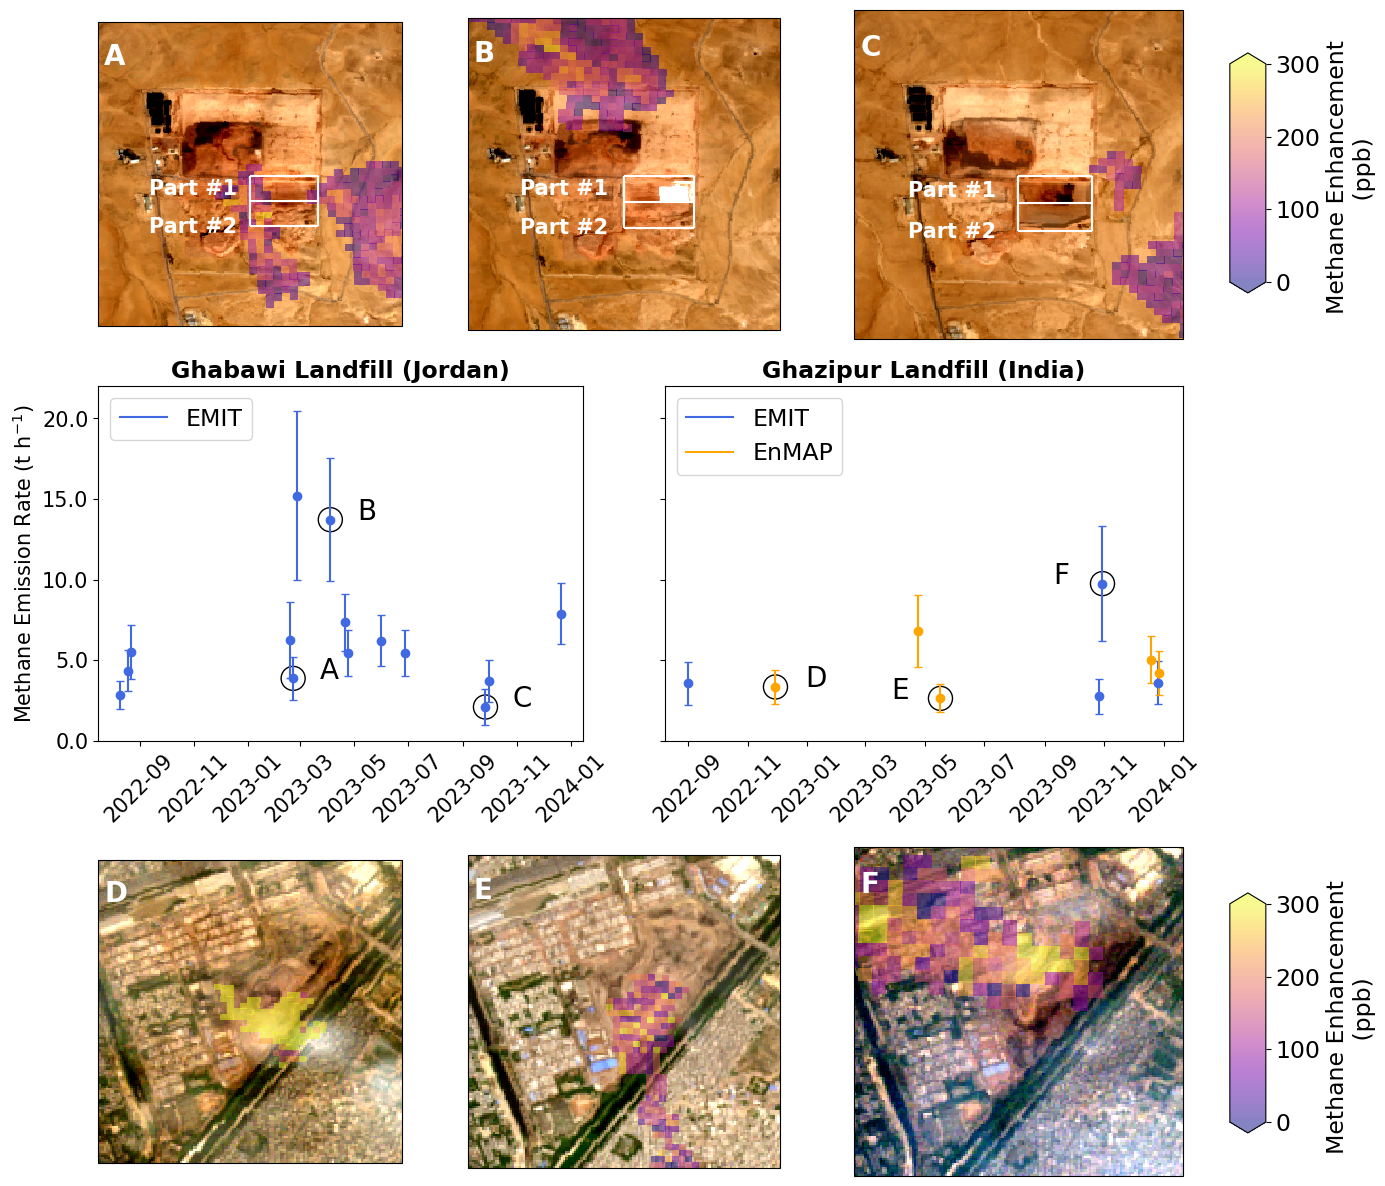

In [21]:
fig, axs = plt.subplot_mosaic(mosaic='AAAABBBBCCCC\nXXXXXXYYYYYY\nDDDDEEEEFFFF',
                              per_subplot_kw={('A', 'B', 'C', 'D', 'E', 'F'): {"projection": ccrs.PlateCarree()}},
                              figsize=(12, 12),
                              constrained_layout=True
                              )


# --- time series ---
ax = axs['X']
df_subset_Ghabawi = df_tseries[df_tseries['name']=='Ghabawi'].sort_values('datetime')
plot_errorbar_stats(ax, df_subset_Ghabawi, title='Ghabawi Landfill (Jordan)')
ax.set_ylabel('Methane Emission Rate (t h$^{-1}$)')

# first case
ax.scatter(df_subset_Ghabawi.iloc[4]['datetime'], df_subset_Ghabawi.iloc[4]['emission'], facecolors='none', edgecolors='k', s=300)
ax.text(df_subset_Ghabawi.iloc[4]['datetime']+pd.Timedelta(days=30), df_subset_Ghabawi.iloc[4]['emission'], 'A', fontsize=20)

# second case
ax.scatter(df_subset_Ghabawi.iloc[6]['datetime'], df_subset_Ghabawi.iloc[6]['emission'], facecolors='none', edgecolors='k', s=300)
ax.text(df_subset_Ghabawi.iloc[6]['datetime']+pd.Timedelta(days=30), df_subset_Ghabawi.iloc[6]['emission'], 'B', fontsize=20)

# third case
ax.scatter(df_subset_Ghabawi.iloc[-3]['datetime'], df_subset_Ghabawi.iloc[-3]['emission'], facecolors='none', edgecolors='k', s=300)
ax.text(df_subset_Ghabawi.iloc[-3]['datetime']+pd.Timedelta(days=30), df_subset_Ghabawi.iloc[-3]['emission'], 'C', fontsize=20)

# --- time series ---

ax = axs['Y']
df_subset_Ghazipur = df_tseries_all[df_tseries_all['name']=='Ghazipur'].sort_values('datetime')
plot_errorbar_stats(ax, df_subset_Ghazipur, title='Ghazipur Landfill (India)')

# first case
ax.scatter(df_subset_Ghazipur.iloc[1]['datetime'], df_subset_Ghazipur.iloc[1]['emission'], facecolors='none', edgecolors='k', s=300)
ax.text(df_subset_Ghazipur.iloc[1]['datetime']+pd.Timedelta(days=30), df_subset_Ghazipur.iloc[1]['emission'], 'D', fontsize=20)

# second case
ax.scatter(df_subset_Ghazipur.iloc[3]['datetime'], df_subset_Ghazipur.iloc[3]['emission'], facecolors='none', edgecolors='k', s=300)
ax.text(df_subset_Ghazipur.iloc[3]['datetime']-pd.Timedelta(days=50), df_subset_Ghazipur.iloc[3]['emission'], 'E', fontsize=20)

# third case
ax.scatter(df_subset_Ghazipur.iloc[-4]['datetime'], df_subset_Ghazipur.iloc[-4]['emission'], facecolors='none', edgecolors='k', s=300)
ax.text(df_subset_Ghazipur.iloc[-4]['datetime']-pd.Timedelta(days=50), df_subset_Ghazipur.iloc[-4]['emission'], 'F', fontsize=20)

# -- Ghabawi cases --
m, extent = plot_case_plume(axs['A'], df_subset_Ghabawi.iloc[4], num=0, data_dir='../data/tseries/Ghabawi')
plot_case_plume(axs['B'], df_subset_Ghabawi.iloc[6], num=1, data_dir='../data/tseries/Ghabawi', extent=extent)
plot_case_plume(axs['C'], df_subset_Ghabawi.iloc[-3], num=2, data_dir='../data/tseries/Ghabawi', extent=extent)

# add cell annotations
for ax in [axs['A'], axs['B'], axs['C']]:
    ax.vlines(x=[36.188, 36.1934], ymin=31.9250, ymax=31.9290, colors='w', zorder=10)
    ax.hlines(y=[31.9250, 31.9270, 31.9290], xmin=36.188, xmax=36.1934, colors='w', zorder=10)
    ax.text(36.18, 31.9275, 'Part #1', c='w', fontweight='bold', fontsize=15)
    ax.text(36.18, 31.9245, 'Part #2', c='w', fontweight='bold', fontsize=15)

# -- Ghazipur cases --
m, extent = plot_case_plume(axs['D'], df_subset_Ghazipur.iloc[1], num=3, data_dir='../data/tseries/Ghazipur', pad=0.007)
plot_case_plume(axs['E'], df_subset_Ghazipur.iloc[3], num=4, data_dir='../data/tseries/Ghazipur', pad=0.007, extent=extent)
plot_case_plume(axs['F'], df_subset_Ghazipur.iloc[-4], num=5, data_dir='../data/tseries/Ghazipur', pad=0.007, extent=extent)


axs['X'].legend(
    loc='upper left',
    handles=[
        Line2D([], [], c='royalblue', label="EMIT"),
    ]
)

axs['Y'].legend(
    loc='upper left',
    # bbox_to_anchor=(0.95, 0.1),
    handles=[
        Line2D([], [], c='royalblue', label="EMIT"),
        Line2D([], [], c='orange', label="EnMAP"),
    ]
)

for ax in [axs['X'], axs['Y']]:
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_ylim(0, 22)
axs['Y'].set_yticklabels([])


# add colorbar
def add_cbar(m, cax):
    cb = fig.colorbar(m, cax=cax, extend='both', orientation="vertical")
    cb.ax.tick_params(labelsize=17)
    cb.ax.set_ylabel('Methane Enhancement \n (ppb)', fontsize=17)

    return cb

cax_1 = fig.add_axes([1.02, 0.05, 0.03, 0.2])
cax_2 = fig.add_axes([1.02, 0.75, 0.03, 0.2])
add_cbar(m, cax_1)
cb = add_cbar(m, cax_2)

fig.savefig('../figures/emission_tseries.pdf', bbox_inches='tight')